# Capstone Project: Part 6 S/ARIMA

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

plt.style.use('fivethirtyeight')

import pmdarima as pmd
import statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.datasets import load_airline
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.compose import AutoEnsembleForecaster
from sktime.utils.plotting import plot_series

# This will allow us to avoid a FutureWarning when plotting.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import warnings # necessary b/c pandas & statsmodels datetime issue
warnings.simplefilter(action="ignore")

In [2]:
# read in training and testing set
tdor = pd.read_csv('../Data/processed_data/tdor_presplit.csv')


In [3]:
tdor['deaths']= 1

In [4]:
# converting the date column to datetime
tdor['date'] = pd.to_datetime(tdor['date'].str.zfill(6), format = '%Y-%m-%d')


In [5]:
# dropping columns that are not needed for time series analysis
tdor = tdor.drop(columns=['name','age','state_province','country','latitude','longitude','category','cause_of_death','description','year','city'])

In [6]:
# Set Date to be in the index
tdor.set_index('date', inplace=True)

# Sort the index
tdor.sort_index(inplace=True)


In [7]:
tdor_monthly = tdor.groupby(pd.Grouper(freq='M')).sum()


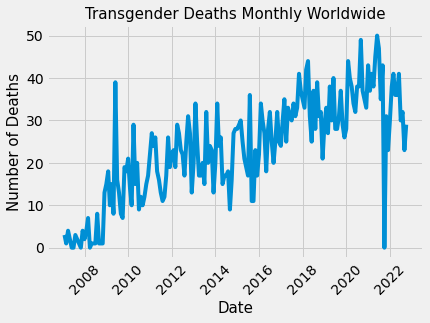

In [8]:
plt.plot(tdor_monthly.index, tdor_monthly['deaths'])
plt.title('Transgender Deaths Monthly Worldwide', fontsize= 15)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Number of Deaths', fontsize=15)
plt.xticks(rotation=45);

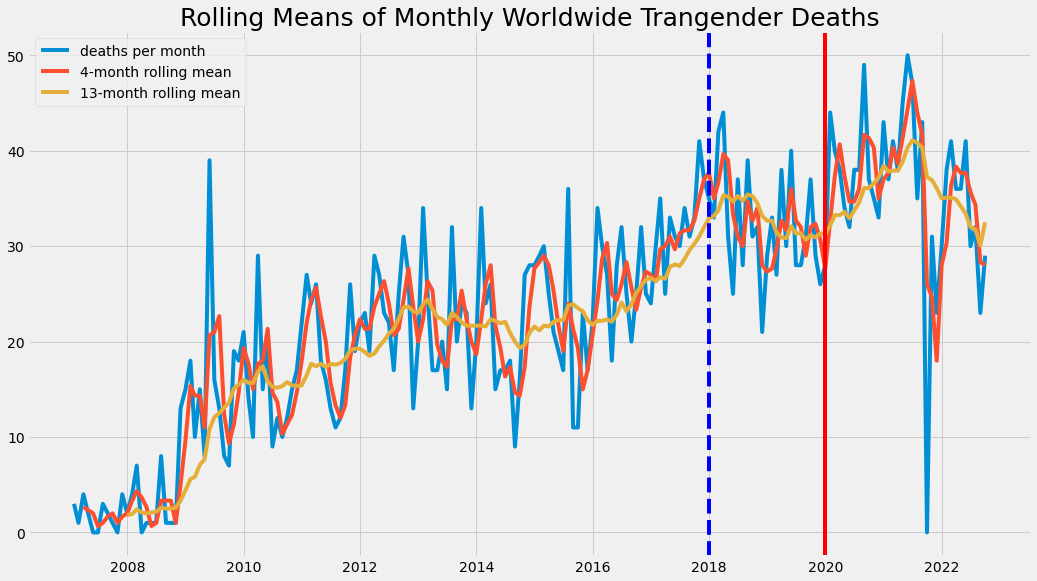

In [9]:
plt.figure(figsize=(16,9))
plt.plot(tdor_monthly['deaths'], label = 'deaths per month')
plt.plot(tdor_monthly['deaths'].rolling(3).mean(), label= '4-month rolling mean')
plt.plot(tdor_monthly['deaths'].rolling(12).mean(), label = '13-month rolling mean')
plt.axvline(x=dt.datetime(2018,1,1),
            color='blue',
            ls='--')
plt.axvline(x=dt.datetime(2020,1,1),
            color='red')
plt.title('Rolling Means of Monthly Worldwide Trangender Deaths', fontsize=25)
plt.legend();


In [10]:
np.corrcoef(tdor_monthly['deaths'][12:], tdor_monthly['deaths'].shift()[12:])


array([[1.        , 0.69317647],
       [0.69317647, 1.        ]])

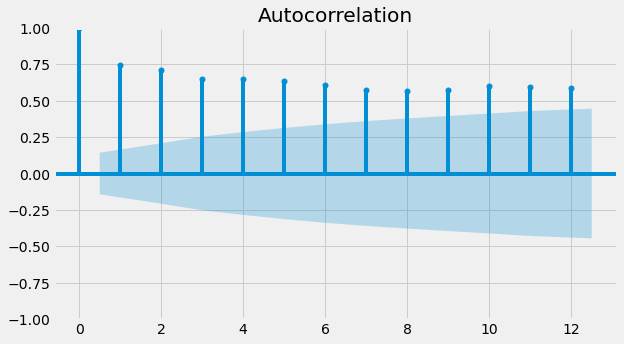

<Figure size 432x288 with 0 Axes>

In [11]:
fig, ax = plt.subplots(figsize=(9,5))
# Plot the autocorrelation plot for Weekly_Sales below:
plot_acf(tdor_monthly, ax=ax, lags=12)
plt.show();
plt.savefig('autocorrelation.png')

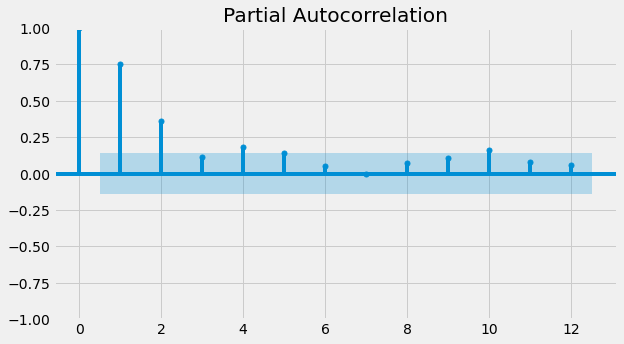

<Figure size 432x288 with 0 Axes>

In [12]:
fig, ax = plt.subplots(figsize=(9,5))
# Plot the partial autocorrelation plot for Weekly_Sales below:
plot_pacf(tdor_monthly, ax=ax, lags=12)
plt.show();
plt.savefig('partialautocorrelation.png')

In [13]:
train, test = train_test_split(tdor_monthly,
                                                    test_size = 0.1,
                                                    shuffle=False) # IMPORTANT!

In [14]:
def test_stationarity(timeseries):
    rolling_mean = timeseries.rolling(window=12,center=False).mean()
    rolling_std = timeseries.rolling(window=12,center=False).std()
    
    figu = plt.figure(figsize=(11,7))
    origin = plt.plot(timeseries, color = 'orange', label = 'Original')
    mean=plt.plot(rolling_mean, color = 'purple', label = 'Rolling Mean')
    std = plt.plot(rolling_std, color = 'green', label = 'Rolling STD')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print('Dickey Fuller Test')
    dickeytest = adfuller(timeseries, autolag='AIC')
    dataframe_output = pd.Series(dickeytest[0:4], index = ['Test Statistic', 'p-value','Lags Used','Observations'])
    for key, value in list(dickeytest[4].items()):
        dataframe_output['Critical Value (%s)' %key] = value
    print(dataframe_output)
                        

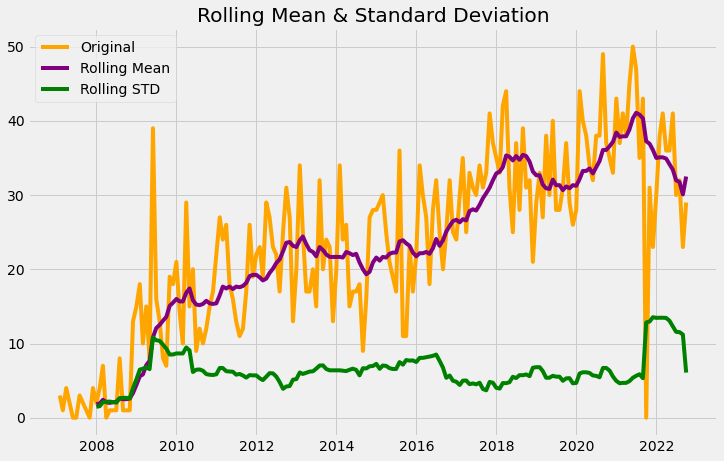

Dickey Fuller Test
Test Statistic           -2.181857
p-value                   0.212896
Lags Used                11.000000
Observations            177.000000
Critical Value (1%)      -3.467845
Critical Value (5%)      -2.878012
Critical Value (10%)     -2.575551
dtype: float64


In [15]:
test_stationarity(tdor_monthly['deaths'])

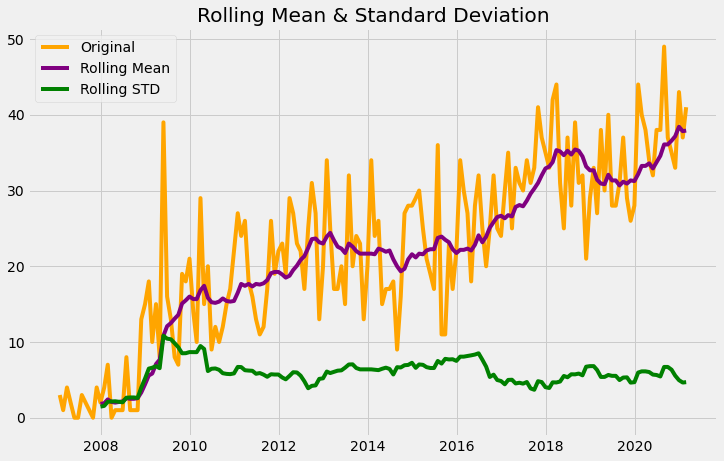

Dickey Fuller Test
Test Statistic           -1.457485
p-value                   0.554428
Lags Used                11.000000
Observations            158.000000
Critical Value (1%)      -3.472431
Critical Value (5%)      -2.880013
Critical Value (10%)     -2.576619
dtype: float64


In [16]:
test_stationarity(train)

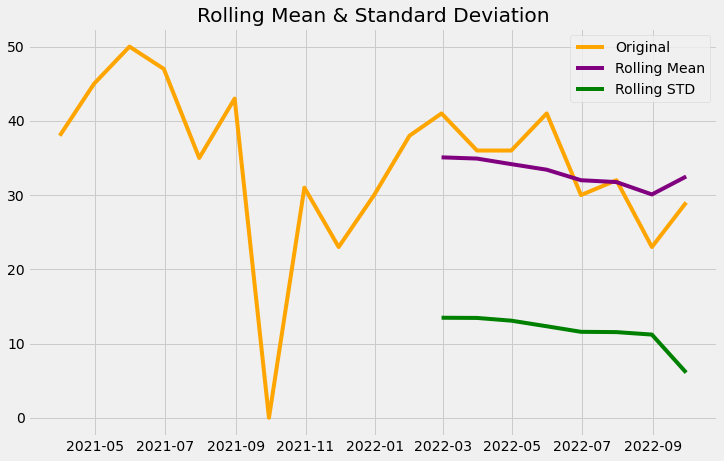

Dickey Fuller Test
Test Statistic          -2.985989
p-value                  0.036224
Lags Used                7.000000
Observations            11.000000
Critical Value (1%)     -4.223238
Critical Value (5%)     -3.189369
Critical Value (10%)    -2.729839
dtype: float64


In [17]:
test_stationarity(test)

In [18]:
df_arima = pd.DataFrame()

In [19]:
ar1 = ARIMA(endog=train['deaths'],order=(1,0,0))
model= ar1.fit()

In [20]:
print(train.shape)
print(test.shape)

(170, 1)
(19, 1)


In [21]:
preds_train = model.predict(start = 170,end=188)
preds_train=pd.DataFrame(preds_train)
preds_train.columns=['deaths']
preds_train.head()

,deaths
2021-03-31,37.001525
2021-04-30,33.849742
2021-05-31,31.365361
2021-06-30,29.407056
2021-07-31,27.863431


In [22]:
preds_test= model.predict(start=1,end=170)
preds_test=pd.DataFrame(preds_test)
preds_test.columns=['deaths']
preds_test.head()

,deaths
2007-02-28,7.048167
2007-03-31,5.471674
2007-04-30,7.836413
2007-05-31,6.259921
2007-06-30,4.683428


In [23]:
mean_squared_error(test['deaths'],preds_train,squared=False)

13.05131989606896

In [24]:
mean_squared_error(train['deaths'],preds_test,squared=False)

2.454326273801825

In [25]:
df_arima['arima order 1,0,0']=preds_train

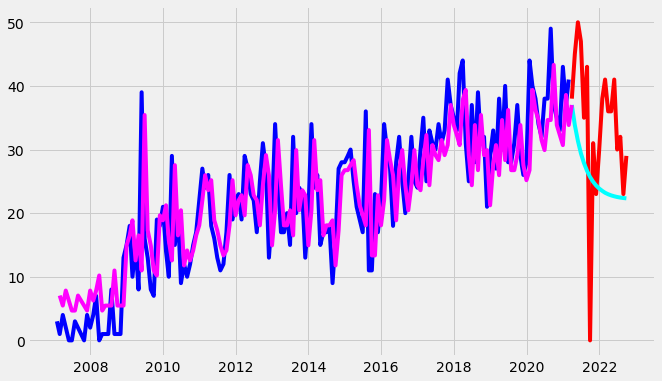

In [26]:
plt.figure(figsize=(10,6))
plt.plot(train['deaths'], color = 'blue')
plt.plot(test['deaths'], color = 'red')
plt.plot(preds_train['deaths'], color = 'cyan')
plt.plot(preds_test['deaths'], color = 'magenta')
plt.show();

In [27]:
ar2 = ARIMA(endog=train['deaths'],order=(2,0,2))
model2= ar2.fit()

In [28]:
preds_train = model2.predict(start = 170,end=188)
preds_train=pd.DataFrame(preds_train)
preds_train.columns=['deaths']
preds_train.head()

,deaths
2021-03-31,38.431561
2021-04-30,37.904903
2021-05-31,37.800106
2021-06-30,37.733645
2021-07-31,37.670869


In [29]:
preds_test= model2.predict(start=1,end=170)
preds_test=pd.DataFrame(preds_test)
preds_test.columns=['deaths']
preds_test.head()

,deaths
2007-02-28,5.026624
2007-03-31,3.154558
2007-04-30,3.987353
2007-05-31,3.173754
2007-06-30,2.214923


In [30]:
mean_squared_error(test['deaths'],preds_train, squared=False)

11.228588232154426

In [31]:
mean_squared_error(train['deaths'],preds_test,squared=False)

4.226246361203211

In [32]:
df_arima['arima order 2,0,2']=preds_train

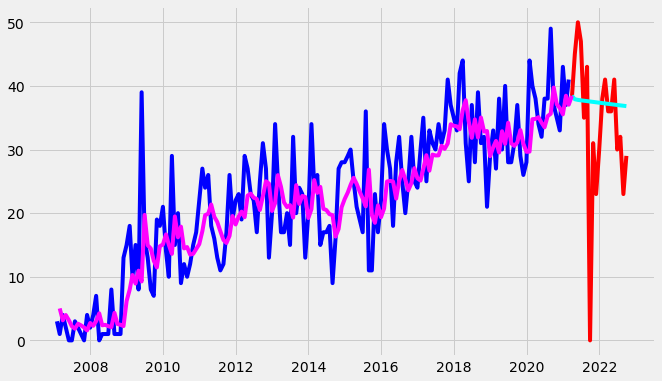

In [33]:
plt.figure(figsize=(10,6))
plt.plot(train['deaths'], color = 'blue')
plt.plot(test['deaths'], color = 'red')
plt.plot(preds_train['deaths'], color = 'cyan')
plt.plot(preds_test['deaths'], color = 'magenta')
plt.show();

In [34]:
ar3 = ARIMA(endog=train['deaths'],order=(2,1,2))
model3= ar3.fit()

In [35]:
preds_train = model3.predict(start = 170,end=188)
preds_train=pd.DataFrame(preds_train)
preds_train.columns=['deaths']
preds_train.head()

,deaths
2021-03-31,39.191102
2021-04-30,38.896298
2021-05-31,38.952751
2021-06-30,39.072831
2021-07-31,39.188721


In [36]:
preds_test= model3.predict(start=1,end=170)
preds_test=pd.DataFrame(preds_test)
preds_test.columns=['deaths']
preds_test.head()

,deaths
2007-02-28,2.999933
2007-03-31,1.767852
2007-04-30,3.086087
2007-05-31,2.379262
2007-06-30,1.499318


In [37]:
mean_squared_error(test['deaths'],preds_train,squared=False)

12.173108335358117

In [38]:
df_arima['arima order 2,1,2']=preds_train

In [39]:
ar4 = ARIMA(endog=train['deaths'],order=(4,0,1))
model4= ar4.fit()

In [40]:
preds_train = model4.predict(start = 170,end=188)
preds_train=pd.DataFrame(preds_train)
preds_train.columns=['deaths']
preds_train.head()

,deaths
2021-03-31,37.873455
2021-04-30,38.067317
2021-05-31,37.663062
2021-06-30,37.942189
2021-07-31,37.880466


In [41]:
preds_test= model4.predict(start=1,end=170)
preds_test=pd.DataFrame(preds_test)
preds_test.columns=['deaths']
preds_test.head()

,deaths
2007-02-28,5.136831
2007-03-31,3.232329
2007-04-30,4.109380
2007-05-31,3.369045
2007-06-30,1.996135


In [42]:
mean_squared_error(test['deaths'],preds_train,squared=False)

11.265401737771244

In [43]:
df_arima['arima order 4,0,1']=preds_train

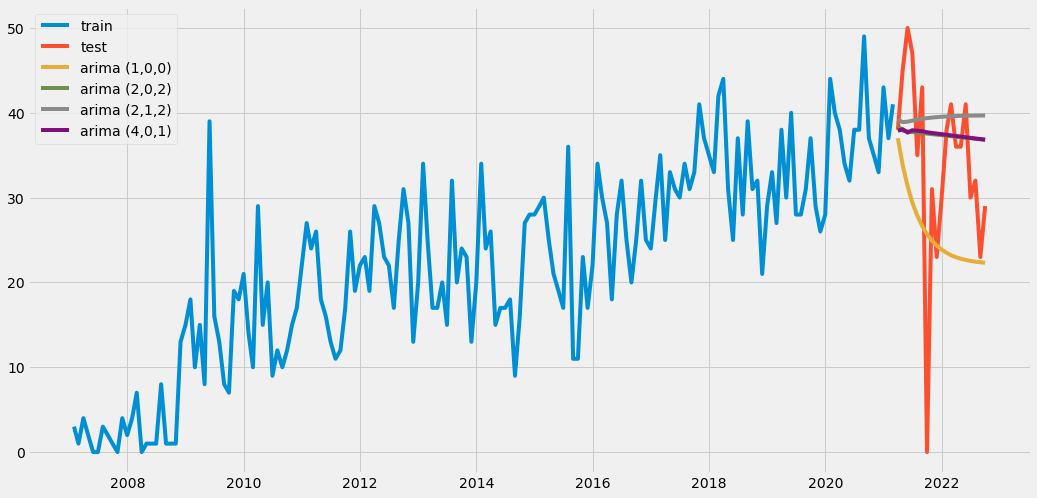

In [75]:
plt.figure(figsize=(16,8))
plt.plot(train['deaths'], label='train')
plt.plot(test['deaths'], label='test')
plt.plot(df_arima['arima order 1,0,0'], label='arima (1,0,0)')
plt.plot(df_arima['arima order 2,0,2'], label='arima (2,0,2)')
plt.plot(df_arima['arima order 2,1,2'], label='arima (2,1,2)')
plt.plot(df_arima['arima order 4,0,1'], label='arima (4,0,1)')
plt.legend();
plt.savefig('monthlyforecastingsdiffarima')

n. The above image describes how different time series analysis models forecast Worldwide transgender deaths.

In [65]:
df_predictions = pd.DataFrame()

In [66]:
sarima = SARIMAX(endog=train['deaths'],
                 order=(2, 0, 2),              # (p, d, q)
                  seasonal_order=(1, 1, 1, 4)) # (P, D, Q, S)

model_sarima = sarima.fit()
preds_sarima = model_sarima.predict(start=170, end=188)
mean_squared_error(test['deaths'], preds_sarima)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.31039D+00    |proj g|=  7.31401D-02

At iterate    5    f=  3.26885D+00    |proj g|=  9.84877D-02

At iterate   10    f=  3.23123D+00    |proj g|=  1.66529D-02

At iterate   15    f=  3.22139D+00    |proj g|=  5.03461D-03

At iterate   20    f=  3.22012D+00    |proj g|=  7.23892D-04

At iterate   25    f=  3.21969D+00    |proj g|=  1.97595D-03

At iterate   30    f=  3.21946D+00    |proj g|=  5.46628D-03

At iterate   35    f=  3.21925D+00    |proj g|=  1.56164D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


171.56750371261288

In [67]:
mean_squared_error(test['deaths'], preds_sarima, squared=False)

13.09837790387088

In [68]:
df_predictions['sarimax']=preds_sarima

In [69]:
model_x = pmd.auto_arima(train['deaths'], m=4, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=1111.108, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=1170.838, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=1146.400, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=1110.644, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=1168.984, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=1108.683, Time=0.03 sec
 ARIMA(0,1,1)(1,0,0)[4] intercept   : AIC=1110.657, Time=0.05 sec
 ARIMA(0,1,1)(1,0,1)[4] intercept   : AIC=1110.606, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=1105.582, Time=0.06 sec
 ARIMA(1,1,1)(1,0,0)[4] intercept   : AIC=1106.991, Time=0.08 sec
 ARIMA(1,1,1)(0,0,1)[4] intercept   : AIC=1106.840, Time=0.10 sec
 ARIMA(1,1,1)(1,0,1)[4] intercept   : AIC=1107.247, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=1144.663, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[4] intercept   : 

In [70]:
preds = model_x.predict(n_periods=test.shape[0])
preds.head()

2021-03-31    39.471242
2021-04-30    39.330749
2021-05-31    39.476589
2021-06-30    39.681487
2021-07-31    39.898566
Freq: M, dtype: float64

In [71]:
df_predictions['auto-arima'] = preds

In [72]:
mean_squared_error(test['deaths'], preds, squared=False)

13.206351786551723

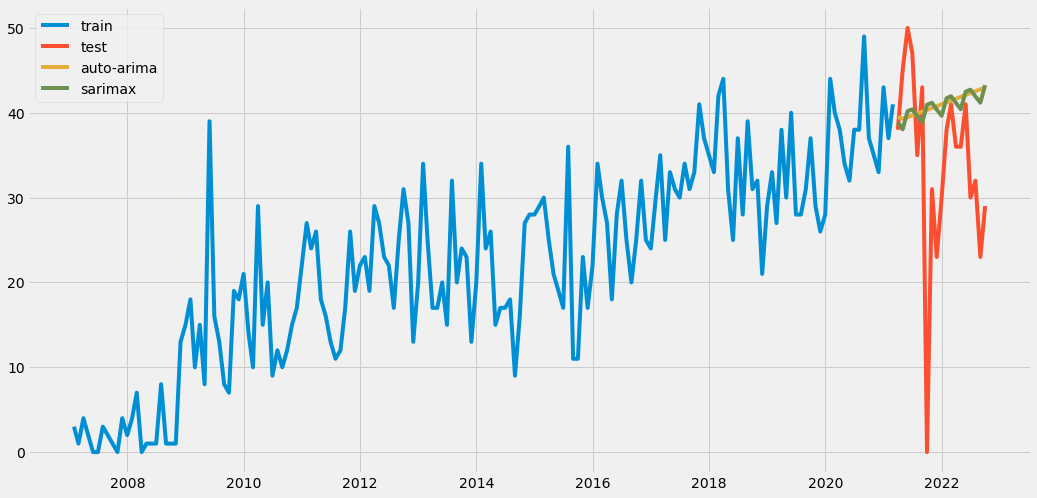

In [74]:
plt.figure(figsize=(16,8))
plt.plot(train['deaths'], label='train')
plt.plot(test['deaths'], label='test')
plt.plot(df_predictions['auto-arima'], label='auto-arima')
plt.plot(df_predictions['sarimax'], label='sarimax')
plt.legend();
plt.savefig('monthlyforecastingsarimaxautoarima')

n. The above image describes how different time series analysis models forecast Worldwide transgender deaths.